# Quantum Approximate Optimization Algorithm (QAOA)
## Maximum cut problem
![maxcut](https://learning-api.quantum.ibm.com/assets/0de75f52-4873-4b5a-a0e9-a351dc48c910?format=auto&quality=80)
The maximum cut problem is a well-known combinatorial optimization problem. Given a graph, the goal is to partition the vertices into two sets such that the number of edges between the two sets is maximized. This problem is NP-hard, and it has applications in clustering, network science, and statistical physics.

https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm

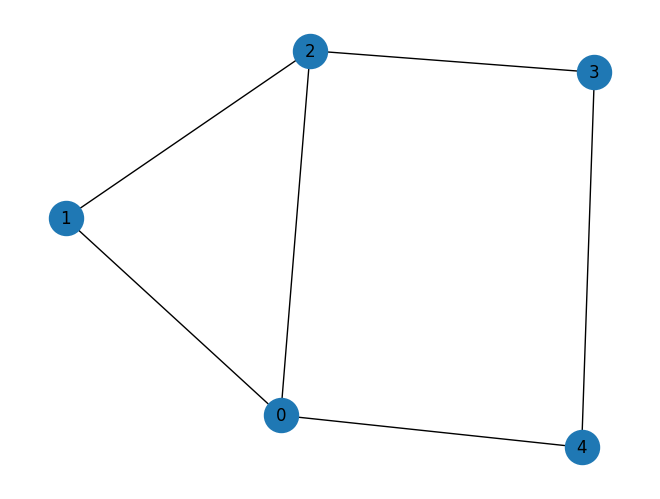

In [14]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

n = 5

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [15]:
from qiskit.quantum_info import SparsePauliOp

def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
  """ Convert the graph to Pauli list.
  this function does the inverse of build_max_cut_graph
  """
  pauli_list = []
  for edge in list(graph.edge_list()):
    paulis = ["I"] * len(graph)
    paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

    weight = graph.get_edge_data(edge[0], edge[1])

    pauli_list.append(("".join(paulis)[::-1], weight))

  return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


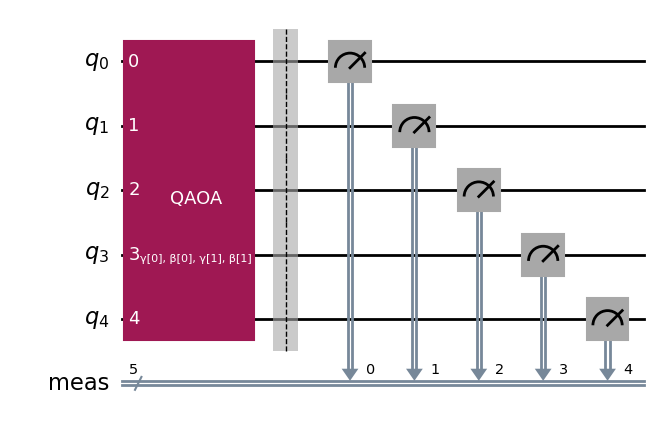

In [16]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw('mpl')

In [17]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

<IBMBackend('ibm_sherbrooke')>


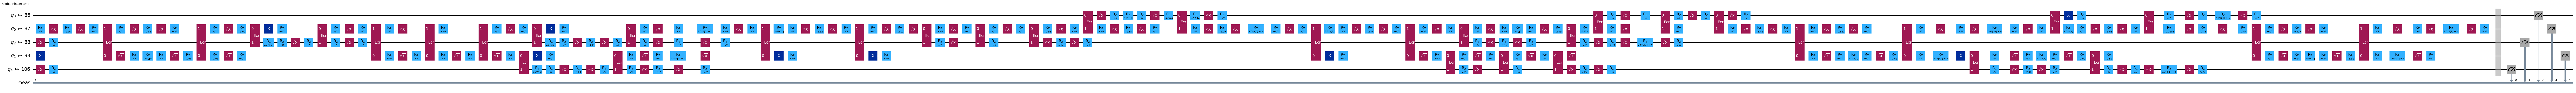

In [20]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# To run this, change to correct personal token
# Do not commit token!
# Intentionally not in an env to prevent multiple runs pulling account out of free plan
ibm_token = ""

QiskitRuntimeService.save_account(channel="ibm_quantum", token=ibm_token, overwrite=True, set_as_default=True)
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(min_num_qubits=127)
print(backend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)